## Retrieve data

In [1]:
import os
from collections import Counter
from tqdm import tqdm


data_dir = "/media/aziz/Data/Aziz/data/gans_for_apr/training/"

print("Collecting file paths...")
file_paths = [root+'/'+name for root, dirs, files in tqdm(os.walk(data_dir)) for name in files]
buggy_paths = [f_path for f_path in tqdm(file_paths) if 'buggy' in f_path]
fixed_paths = [f_path for f_path in tqdm(file_paths) if 'fixed' in f_path]

print("Collecting file contents...")
buggy_data = []
for path in tqdm(buggy_paths):
    with open(path, 'r', encoding='utf-8') as f:
        buggy_data.append(f.read())
fixed_data = []
for path in tqdm(fixed_paths):
    with open(path, 'r', encoding='utf-8') as f:
        fixed_data.append(f.read())

print('Number of processed files:-')
print(len(buggy_data), 'buggy files +', len(fixed_data), 'fixed files = ', len(buggy_data)+len(fixed_data), 'files')

4884it [00:00, 48838.65it/s]

21757it [00:00, 56483.32it/s]
 45%|████▌     | 9863/21756 [00:00<00:00, 47368.62it/s]

100%|██████████| 21756/21756 [00:00<00:00, 53540.44it/s]

Number of processed files:-
21756 buggy files + 21756 fixed files =  43512 files


## Clean data - Reduce noise

### Remove comments

In [2]:
import re


def remove_comments(code):
    code = re.sub('(?s)/\*.*?\*/', '', code)
    return re.sub('(//[^\n]*)', '', code)


buggy_no_comments = [remove_comments(x) for x in tqdm(buggy_data)]
fixed_no_comments = [remove_comments(x) for x in tqdm(fixed_data)]
print('Comments have been removed')

100%|██████████| 21756/21756 [00:00<00:00, 110012.87it/s]

Comments have been removed


### Remove unnecessary white spaces

In [3]:
def remove_spaces(code):
    '''This function removes excessive spaces and keeps necessary ones'''
    code = code.splitlines()
    result = []
    for line in code:
        line = line.split()
        line = ' '.join(line)
        if len(line) > 0:  # Remove empty lines
            result.append(line)
    
    return '\n'.join(result)


buggy_no_spaces = [remove_spaces(x) for x in tqdm(buggy_no_comments)]
fixed_no_spaces = [remove_spaces(x) for x in tqdm(fixed_no_comments)]
print('White spaces have been removed')

100%|██████████| 21756/21756 [00:00<00:00, 30354.04it/s]

White spaces have been removed


### Remove identical buggy and fixed codes

In [4]:
buggy_texts, fixed_texts = [], []
for buggy, fixed in zip(buggy_no_spaces, fixed_no_spaces):
    if buggy != fixed:
        buggy_texts.append(buggy)
        fixed_texts.append(fixed)
print(len(buggy_no_spaces)-len(buggy_texts), 'code pairs have been removed')
print('Current # data points:', len(buggy_texts))

4726 code pairs have been removed
Current # data points: 17030


### Remove duplicated pairs in the dataset

In [5]:
text_pairs = [(x, y) for x, y in zip(buggy_texts, fixed_texts)]
code_pairs = sorted(set(text_pairs))  # Sorted to ensure same order every run (not sure if 'set' works randomly)

buggy_codes = [x[0] for x in code_pairs]
fixed_codes = [x[1] for x in code_pairs]

print(len(text_pairs)-len(code_pairs), 'code pairs have been removed')
print('Current # data points:', len(buggy_codes))

3857 code pairs have been removed
Current # data points: 13173


## Calculate Diffs

In [6]:
from difflib import ndiff


initial_diffs = [list(ndiff(x.splitlines(), y.splitlines())) for x, y in tqdm(zip(buggy_codes, fixed_codes))]

13173it [00:03, 3877.75it/s]


### Restrict to one-line difference

In [7]:
one_line_diffs = []
for diff in tqdm(initial_diffs):
    if sum([1 for x in diff if x.startswith('-')]) > 1 or sum([1 for x in diff if x.startswith('+')]) > 1:
        continue
    one_line_diffs.append(diff)

print(len(initial_diffs)-len(one_line_diffs), 'code pairs have been removed')
print('Current # data points:', len(one_line_diffs))

100%|██████████| 13173/13173 [00:00<00:00, 68755.57it/s]

322 code pairs have been removed
Current # data points: 12851


### Restrict to modified lines (exclude added/deleted lines)

In [8]:
diffs = []
for diff in tqdm(one_line_diffs):
    for i, x in enumerate(diff):
        if x.startswith('+') and diff[i-1].startswith('-'):
            diffs.append((diff[i-1][2:], x[2:]))

print(len(one_line_diffs)-len(diffs), 'code pairs have been removed')
print('Current # data points:', len(diffs))

100%|██████████| 12851/12851 [00:00<00:00, 80309.61it/s]

7102 code pairs have been removed
Current # data points: 5749


#### Shuffle and separate training and testing data

In [9]:
from random import seed, sample


seed(30)
shuf_diffs = sample(diffs, k=len(diffs))
test_diffs, train_diffs = shuf_diffs[:500], shuf_diffs[500:]

train_buggy_lines = [x[0] for x in train_diffs]
train_fixed_lines = [x[1] for x in train_diffs]

test_buggy_lines = [x[0] for x in test_diffs]
test_fixed_lines = [x[1] for x in test_diffs]

500 5249


# The Experiment

In [10]:
import javalang


def create_tokenised(code_lines, fixed=False):
    code_streams = [javalang.tokenizer.tokenize(x, ignore_errors=True) for x in code_lines]
    code_tokenised = []
    for code in code_streams:
        code_tokenised.append([x.value for x in code])
    if fixed:
        return [['<sol>']+x+['<eol>'] for x in code_tokenised]
    else:
        return code_tokenised
    

train_buggy_tokenised = create_tokenised(train_buggy_lines)
train_fixed_tokenised = create_tokenised(train_fixed_lines, True)
test_buggy_tokenised = create_tokenised(test_buggy_lines)
test_fixed_tokenised = create_tokenised(test_fixed_lines, True)


print("Before vectorisation:-")
print(train_buggy_lines[2])
print(train_fixed_lines[2])
print("====================")
print("After vectorisation:-")
print(train_buggy_tokenised[2])
print(train_fixed_tokenised[2])

Before vectorisation:-
cacheManager = new CacheManagerFactory().instantiateCacheManager();
cacheManager = new DefaultCacheManagerFactory().instantiateCacheManager();
After vectorisation:-
['cacheManager', '=', 'new', 'CacheManagerFactory', '(', ')', '.', 'instantiateCacheManager', '(', ')', ';']
['<sol>', 'cacheManager', '=', 'new', 'DefaultCacheManagerFactory', '(', ')', '.', 'instantiateCacheManager', '(', ')', ';', '<eol>']


In [11]:
vocab = set([x for y in train_buggy_tokenised for x in y]+[x for y in train_fixed_tokenised for x in y])
token_int_map = dict([(token, i+1) for i, token in enumerate(vocab)])
vocab.add('<pad/unknown>')
token_int_map['<pad/unknown>'] = 0
int_token_map = dict((i, token) for token, i in token_int_map.items())

In [12]:
print(int_token_map)

{1: 'TempletonControllerJob', 2: 'setThresholdFrequency', 3: 'PigStats', 4: 'PublicLbProvider', 5: 'expectedMessageCount', 6: 'Expression', 7: 'createQuery', 8: 'setStore', 9: '"ValidatorDialog.Dialog.AddAllowedValue.Title"', 10: 'getEncodedName', 11: 'columnTypes', 12: 'extract', 13: 'AbstractFigureParameter_Behavior', 14: 'TypeExtractor', 15: 'metrics', 16: 'openFromFS', 17: 'auth', 18: 'usesJobShell', 19: '" @ "', 20: '0.5f', 21: 'newarray', 22: 'DATACLUSTER_DATARANGE', 23: 'getDelimiter', 24: 'PlanetModel', 25: 'NGramTokenFilter', 26: 'isFullAcidRead', 27: 'TezResourceManager', 28: 'shortcut', 29: 'MORE_OR_EQUALS_SIGN', 30: 'checkType', 31: 'login', 32: 'pointFormat', 33: 'bfBytes', 34: 'binarizer', 35: '"HTTP"', 36: 'TestEnvironment', 37: 'AbstractEditorComponent', 38: 'filterNeedReview', 39: 'putRegionState', 40: 'addressUri', 41: 'queryArea', 42: "')'", 43: 'sumTotalTermFreq', 44: 'getCountsStore', 45: 'AnalysisTestsHelper', 46: 'errorHandler', 47: 'title', 48: 'createTimestamp'

In [13]:
vocab_size = len(vocab)
max_buggy_len = max([len(txt) for txt in train_buggy_tokenised])
max_fixed_len = max([len(txt) for txt in train_fixed_tokenised])
num_dps = len(train_fixed_tokenised)
num_test_dps = len(test_fixed_tokenised)

# test_buggy_codes = [x for x in test_buggy_codes if len(x) <= max_buggy_len]
# test_fixed_codes = [x for x in test_fixed_codes if len(x) <= max_fixed_len]

In [14]:
print('Number of data points:', num_dps)
print('Vocabulary size:', vocab_size)
print('Max length in buggy codes:', max_buggy_len)
print('Max length in fixed codes:', max_fixed_len)

Number of data points: 5249
Vocabulary size: 11216
Max length in buggy codes: 81
Max length in fixed codes: 64


In [15]:
import numpy as np

buggy_inputs =  np.zeros((num_dps, max_buggy_len), dtype='int32')
fixed_inputs =  np.zeros((num_dps, max_fixed_len), dtype='int32')
fixed_outputs = np.zeros((num_dps, max_fixed_len, vocab_size), dtype='float32')

for i, (buggy, fixed) in enumerate(zip(train_buggy_tokenised, train_fixed_tokenised)):
    for t, token in enumerate(buggy):
        buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        int_value = token_int_map[token]
        fixed_inputs[i, t] = int_value
        if t > 0:
            fixed_outputs[i, t-1, int_value] = 1.
    fixed_outputs[i, t, 0] = 1.


test_buggy_inputs =  np.zeros((num_test_dps, max_buggy_len), dtype='int32')
test_fixed_inputs =  np.zeros((num_test_dps, max_fixed_len), dtype='int32')

for i, (buggy, fixed) in enumerate(zip(test_buggy_tokenised, test_fixed_tokenised)):
    for t, token in enumerate(buggy):
        if token not in list(token_int_map.keys()):
            test_buggy_inputs[i, t] = token_int_map['<pad/unknown>']
        else:
            test_buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        if token not in list(token_int_map.keys()):
            test_fixed_inputs[i, t] = token_int_map['<pad/unknown>']
        else:
            test_fixed_inputs[i, t] = token_int_map[token]

In [16]:
from keras.layers import Input, Concatenate, Embedding, LSTM, Dense, dot, Activation, concatenate, Lambda
from keras.models import Model
from keras.backend import argmax, cast


def build_discriminator(dimension, v_size, buggy_len, fixed_len):
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    concatted = Concatenate()([buggy_input_layer, fixed_input_layer])
    embed_lay = Embedding(v_size, dimension, mask_zero=True)(concatted)
    x = LSTM(dimension)(embed_lay)
    out = Dense(1, activation='sigmoid')(x)
    disc = Model([buggy_input_layer, fixed_input_layer], out)
    disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], loss_weights=[0.5])
    
    return disc


def build_generator(dimension, v_size, drop_prob, buggy_len, fixed_len):
    # Encoder
    buggy_input_layer = Input(shape=(buggy_len,))
    enc_embed_lay = Embedding(v_size, dimension, mask_zero=True)(buggy_input_layer)
    encoder_outputs, state_h, state_c = LSTM(dimension, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob)(enc_embed_lay)
    # Decoder
    fixed_input_layer = Input(shape=(fixed_len,))
    dec_embed_lay = Embedding(v_size, dimension, mask_zero=True)(fixed_input_layer)
    decoder_outputs = LSTM(dimension, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)(dec_embed_lay, initial_state=[state_h, state_c])
    # Attention
    attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)
    context = dot([attention, encoder_outputs], axes=[2, 1])
    decoder_combined_context = concatenate([context, decoder_outputs])
    attention_context_output = Dense(dimension, activation="tanh")(decoder_combined_context)
    # Model output
    model_output = Dense(v_size, activation="softmax")(attention_context_output)
    # Build model
    gen = Model([buggy_input_layer, fixed_input_layer], model_output)
    
    return gen


def build_gan(gen, disc, buggy_len, fixed_len):
    disc.trainable = False
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    gen_out = gen([buggy_input_layer, fixed_input_layer])
    argmax_layer = Lambda(lambda x: cast(argmax(x, axis=2), dtype='float32'))
    disc_out = disc([buggy_input_layer, argmax_layer(gen_out)])
    gan = Model([buggy_input_layer, fixed_input_layer], [disc_out, gen_out])
    # compile model
    gan.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer='rmsprop', loss_weights=[1, 100])
    
    return gan

Using TensorFlow backend.


W1017 12:09:00.366342 140472994461440 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1017 12:09:00.376936 140472994461440 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1017 12:09:00.381295 140472994461440 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1017 12:09:01.392209 140472994461440 deprecation.py:323] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.ar

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 81)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 64, 11216)    53350352    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64)           0           model_2[1][0]                    
__________

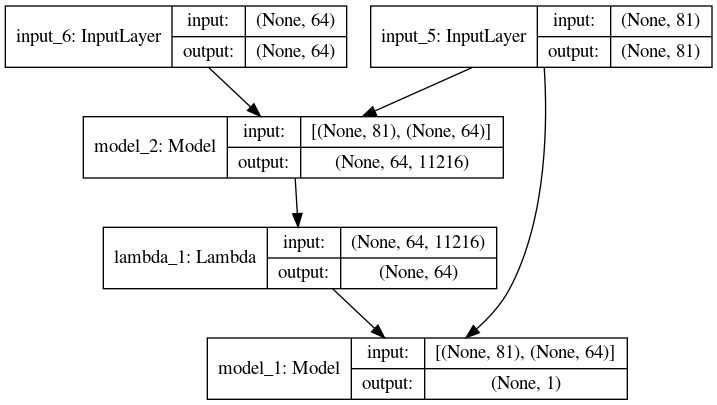

In [17]:
%matplotlib inline
from keras.utils.vis_utils import plot_model
from IPython.display import Image


latent_dim = 1024
dropout = 0.2

discriminator = build_discriminator(latent_dim, vocab_size, max_buggy_len, max_fixed_len)
plot_model(discriminator, to_file='discriminator_apr.png', show_shapes=True, show_layer_names=True)
# Image('discriminator_model_plot.png')

generator = build_generator(latent_dim, vocab_size, dropout, max_buggy_len, max_fixed_len)
plot_model(generator, to_file='generator_apr.png', show_shapes=True, show_layer_names=True)
# Image('generator_model_plot.png')

gan = build_gan(generator, discriminator, max_buggy_len, max_fixed_len)
plot_model(gan, to_file='gan_model_apr.png', show_shapes=True, show_layer_names=True)
gan.summary()
Image('gan_model_apr.png')

In [18]:
def generate_fixed_ints(gen, bugs, fixed_len, token_map, int_map):
    gntd_ints = np.zeros(shape=(len(bugs), fixed_len))
    gntd_ints[:, 0] = token_map["<sol>"]
    for buggy, generated in tqdm(zip(bugs, gntd_ints), total=len(bugs)):
        buggy_input = buggy[np.newaxis]
        gntd_in_out = generated[np.newaxis]
        for i in range(1, fixed_len):
            prediction = gen.predict([buggy_input, gntd_in_out]).argmax(axis=2)
            if int_map[prediction[:, i][0]] == "<eol>":
                break
            generated[i] = prediction[:, i]
    
    return gntd_ints


def decode_ints(int_matrix, int_map):
    gntd_codes = []
    for ints in int_matrix:
        code = [int_map[x] for x in ints if x != 0]
        gntd_codes.append(code)
        
    return gntd_codes

In [ ]:
import datetime
from tqdm import tqdm


epochs = 30

start_time = datetime.datetime.now().replace(microsecond=0)
for e in range(epochs):
    print('Iteration', str(e+1)+'/'+str(epochs)+':-')
    discriminator.fit([buggy_inputs, fixed_inputs], np.ones(num_dps))
    generated_ints = generate_fixed_ints(generator, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
    discriminator.fit([buggy_inputs, generated_ints], np.zeros(num_dps))
    gan.fit([buggy_inputs, fixed_inputs], [np.ones(num_dps), fixed_outputs])
    generated_ints = generate_fixed_ints(generator, test_buggy_inputs, max_fixed_len, token_int_map, int_token_map)
    generated_codes = decode_ints(generated_ints, int_token_map)
    for buggy, fixed, gnrtd in zip(test_buggy_tokenised, test_fixed_tokenised, generated_codes):
        print('Buggy code:', ' '.join(buggy))
        print('---')
        print('Fixed code:', ' '.join(fixed[1:-1]))
        print('Genration: ', ' '.join(gnrtd[1:]))
        print('=============')
        print('=============')
end_time = datetime.datetime.now().replace(microsecond=0)

Iteration 1/30:-


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
5249/5249 [==============================] - 40s 8ms/step - loss: 0.0041 - acc: 1.0000


 26%|██▋       | 1379/5249 [1:41:11<4:43:17,  4.39s/it]

In [ ]:
print("Training took (h:mm:ss)", end_time-start_time)

In [ ]:
generated_ints = generate_fixed_ints(generator, test_buggy_inputs, max_fixed_len, token_int_map, int_token_map)
generated_codes = decode_ints(generated_ints, int_token_map)
for buggy, fixed, gnrtd in zip(test_buggy_tokenised, test_fixed_tokenised, generated_codes):
    print('Buggy code:', ' '.join(buggy))
    print('---')
    print('Fixed code:', ' '.join(fixed[1:-1]))
    print('Genration: ', ' '.join(gnrtd[1:]))
    print('=============')
    print('=============')